<a href="https://colab.research.google.com/github/manzoniandrea/Geo-reconstruction_-ANN/blob/main/dataCategorization/Lombardia/lithology_Lom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

file richiesti:
CSV per tutte le province della lombardia
DEM_clip.tif

#Install Libraries

In [ ]:
pip install pyvista

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 21.4 MB/s 
     |████████████████████████████████| 88.3 MB 140 kB/s 
     |████████████████████████████████| 1.1 MB 42.9 MB/s 
     |████████████████████████████████| 144 kB 42.6 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 271 kB 72.8 MB/s 


In [ ]:
pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 24.0 MB/s 


In [ ]:
pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 359 kB/s 


In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 20.5 MB/s 
     |████████████████████████████████| 16.7 MB 338 kB/s 


#Import libraries

In [ ]:
import pandas as pd
import pyvista as pv
import numpy as np
import vtk

#Import Data
data source: https://www.geoportale.regione.lombardia.it/it/metadati?p_p_id=detailSheetMetadata_WAR_gptmetadataportlet&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&_detailSheetMetadata_WAR_gptmetadataportlet_uuid=%7BDAF98B21-3257-4D23-9D53-5AECC966D872%7D

In [ ]:
wellVarese = pd.read_excel('bdgs_012_Varese.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellSondrio = pd.read_excel('bdgs_014_Sondrio.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellPavia = pd.read_excel('bdgs_018_Pavia.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellMonza_e_della_Brianza = pd.read_excel('bdgs_108_Monza_e_della_Brianza.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellMilano = pd.read_excel('bdgs_015_Milano.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellMantova = pd.read_excel('bdgs_020_Mantova.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellLodi = pd.read_excel('bdgs_098_Lodi.xlsx',usecols ='A,C,E,O,P,V,AM,AN')
wellLecco = pd.read_excel('bdgs_097_Lecco.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellCremona = pd.read_excel('bdgs_019_Cremona.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellComo = pd.read_excel('bdgs_013_Como.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellBrescia = pd.read_excel('bdgs_017_Brescia.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')
wellBergamo = pd.read_excel('bdgs_016_Bergamo.xlsx',usecols = 'A,C,E,O,P,V,AM,AN')

frames = [wellVarese, wellSondrio, wellPavia, wellMonza_e_della_Brianza, wellMilano, wellMantova, wellLodi, wellLecco, wellCremona, wellComo, wellBrescia, wellBergamo]

wellLoc = pd.concat(frames)


#Data preprocess

In [ ]:
from pyproj import Transformer

transformer = Transformer.from_crs('epsg:3003','esri:54012',always_xy=True)
points = list(zip(wellLoc.Coord_X_GB,wellLoc.Coord_Y_GB))
coordsConv = np.array(list(transformer.itransform(points)))
wellLoc['Easting'] = coordsConv[:,0]
wellLoc['Northing'] = coordsConv[:,1]
wellLoc = wellLoc.sort_values(by=['ide', 'nr_livello'],ignore_index=1)

the digital elevatio model used to evaluate the wellhead elevation (DEM_clip.tif) is derived form: https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1:

In [ ]:
import rasterio
import geopandas as gpd

src = rasterio.open('DEM_clip.tif')
coords = [(x,y) for x, y in zip( wellLoc.Easting, wellLoc.Northing)]

wellLoc.index = range(len(wellLoc))
wellLoc['quota'] = [x[0] for x in src.sample(coords)]

In [ ]:
offsetList = []
linSec = []
linVerts = []

i = 0

botLito = np.zeros(wellLoc.spessore_livello.size)
topLito = np.zeros(wellLoc.spessore_livello.size)

for layer in range(0,wellLoc.spessore_livello.size):
  x,y,z = wellLoc.loc[layer][['Easting','Northing','quota']]
  if layer == 0:
    topLito[0] = wellLoc.quota[0]
    botLito[0] = topLito[0] - wellLoc.spessore_livello[0]/100
  elif wellLoc.ide[layer] == wellLoc.ide[layer-1]:
    topLito[layer] =  botLito[layer-1]
    botLito[layer] = topLito[layer] - wellLoc.spessore_livello[layer]/100
  else:
    topLito[layer] = wellLoc.quota[layer]
    botLito[layer] = topLito[layer] - wellLoc.spessore_livello[layer]/100
  cellVerts = [[x,y,topLito[layer]],[x,y,botLito[layer]]]
  offsetList.append(i*3)
  linSec = linSec + [2,2*i,2*i+1]
  linVerts = linVerts + cellVerts
  i+=1

offsetArray = np.array(offsetList)
linArray = np.array(linSec)
cellType = np.ones([i])*3
vertArray = np.array(linVerts)

wellLoc['top_Layer'] = topLito
wellLoc['bttom_Layer'] =  botLito


In [ ]:
litoDict =  {}

i=0
for lito in wellLoc.l1_descr.unique():
  litoDict[lito] = wellLoc.l1.unique()[i]
  i += 1



#data chategrories reduction:
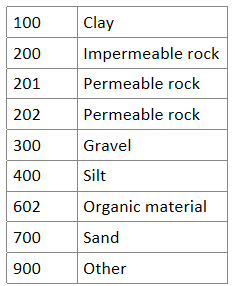

In [ ]:
#reduce the number of cathegories

cate = np.array(wellLoc.l1,dtype=int )
for j in range(len(cate)):
  if (cate[j]==900 or cate[j]==100 or cate[j]==306 or 
      cate[j]==201 or cate[j]==202 or cate[j]==300 or
      cate[j]==400 or cate[j]==602 or cate[j]==700 or cate[j]==200):
    a=1
  elif cate[j]==204:
    cate[j]=200
  elif cate[j]==309:
    cate[j]=306
  elif cate[j]==307:
    cate[j]=303
  elif wellLoc.l1[j]==1000:
    cate[j]=900
  elif cate[j]==304:
    cate[j]=300
  elif cate[j]==308:
    cate[j]=303
  elif cate[j]==305:
    cate[j]=701
  elif cate[j]==301:
    cate[j]=310
  elif cate[j]==705:
    cate[j]=400
  elif cate[j]==9999:
    cate[j]=900
  elif cate[j]==601:
    cate[j]=700
  elif cate[j]==203:
    cate[j]=201
  elif cate[j]==502:
    cate[j]=900
  elif cate[j]==311:
    cate[j]=900
  elif cate[j]==706:
    cate[j]=700
  elif cate[j]==705:
    cate[j]=704
  elif cate[j]==702:
    cate[j]=701
  elif cate[j]==1003:
    cate[j]=602
  elif cate[j]==501:
    cate[j]=602
  elif cate[j]==800:
    cate[j]=602
  elif cate[j]==1002:
    cate[j]=602
  elif cate[j]==603:
    cate[j]=602
  elif cate[j]==703:
    cate[j]=700
  elif cate[j]==704:
    cate[j]=700
  elif cate[j]==701:
    cate[j]=700
  elif cate[j]==303:
    cate[j]=300
  elif cate[j]==302:
    cate[j]=300
  elif cate[j]==1001:
    cate[j]=900
  elif cate[j]==500:
    cate[j]=602
  elif cate[j]==0:
    cate[j]=900

In [ ]:
#reduce the number of cathegories
wellLoc.l1 = cate

#Save and export data

In [ ]:
grid = pv.UnstructuredGrid(offsetArray, linArray, cellType, vertArray)
grid.cell_arrays["values"] = wellLoc.l1.values
grid.save('wellLito.vtu',binary=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: VTK 9 no longer accepts an offset array
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pyvista/core/dataset.py:1557: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  PyvistaDeprecationWarning,


In [ ]:
wellLoc.to_csv('wellLito.csv')

In [ ]:
from google.colab import files
files.download('wellLito.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>